# How could Olist increase its profit? 

Analysis by Oscar Schraenkler

## Problem Statement

Olist is a leading e-commerce service that connects merchants to main marketplaces in Brazil. They have made a dataset available with information about 100k orders from 2016 to 2018. Read more about Olist on their website: www.olist.com

As an analyst, I will see whether I can find inefficiencies in Olists business and make a data-driven recommendation on how they can increase their profit margin.

**Approach:**

The dataset includes reviews for each product sold on the platform. By making assumptions about the financial cost of negative reviews to Olist, I can identify the underperforming sellers and remove them to increase Olists profit.

❓ How many underperforming sellers should Olist remove to improve its profit, given that it has:

- Some revenue per seller per months
- Some revenue per order
- Some reputation costs (estimated) per bad review
- Some operational costs of the IT system that grows with number of orders, but not linearly (scale effects)

## P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

## Imports & Loading Data

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

### Loading data

In [2]:
from olist.seller import Seller
from olist.data import Olist
data = Olist().get_data() #dictionary with all data from the dataset as DataFrames, stored in data.py
sellers = Seller().get_training_data() #DataFrame prepared for this analysis, stored in seller.py

### Displaying the sellers dataframe

In [3]:
display(sellers.head(5))
display(sellers.describe())

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.725000,0.050000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,0.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,1.000000,0.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,0.000000,1.000000,1.00


,delay_to_carrier,wait_time,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
count,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,0.385636,12.139417,6.025615,33.650489,37.897203,1.157337,4568.852187,0.595077,0.120886,4.101513
std,2.295812,7.069233,5.994211,107.182856,121.514362,0.439557,14191.836779,0.278763,0.188857,0.801517
min,0.000000,1.214178,0.000000,1.000000,1.000000,1.000000,6.500000,0.000000,0.000000,1.000000
25%,0.000000,8.287658,1.000000,2.000000,3.000000,1.000000,239.850000,0.493022,0.000000,3.846154
50%,0.000000,11.115143,4.000000,7.000000,8.000000,1.000000,896.000000,0.600000,0.058824,4.210526
75%,0.000000,14.231984,10.000000,23.000000,26.000000,1.142857,3583.995000,0.750000,0.159043,4.626453
max,45.434039,189.863160,23.000000,1854.000000,2033.000000,15.000000,229472.630000,1.000000,1.000000,5.000000


We can see that the Sellers dataframe consists of 2967 entries representing unique sellers on the Olist platform with the following features:
  
| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `seller_id` 	| str 	| the id of the seller **UNIQUE** 	|
| `seller_city` 	| str 	| the city where seller is located 	|
| `seller_state` 	| str 	| the state where seller is located 	|
| `delay_to_carrier` 	| float 	| returns 0 if the order is delivered before the shipping_limit_date, otherwise the value of the delay 	|
| `wait_time` 	| float 	| average wait_time (duration of deliveries) per seller 	|
| `date_first_sale` 	| datetime 	| date of the first sale on Olist 	|
| `date_last_sale` 	| datetime 	| date of the last sale on Olist 	|
| `months_on_olist` 	| float 	| round number of months  on Olist	|
| `share_of_five_stars` 	| float 	| share of five-star reviews for orders in which the seller was involved 	|
| `share_of_one_stars` 	| float 	| share of one-star reviews for orders in which the seller was involved 	|
| `review_score` 	| float 	| average review score for orders in which the seller was involved 	|
| `n_orders` 	| int 	| number of unique orders the seller was involved with 	|
| `quantity` 	| int 	| total number of items sold by this seller 	|
| `quantity_per_order` 	| float 	| average number of items per order for this seller 	|
| `sales` 	| float 	| total sales associated with this seller (excluding freight value) in BRL 	|  

## Data Preparation

For each seller, I will compute the cumulated:
- `revenue` the seller brings to Olist: sum of subscription and sales fees revenues.
- `cost_of_reviews` associated with all the seller's bad reviews: sum of costs associated with bad reviews.
- resulting `profits`: revenues - costs.
- `n_products`, the number of products the seller has sold: taken from the quantity colum of the sellers DataFrame.

### Calculating revenue per seller

In [4]:
seller_df = pd.DataFrame()
seller_df['seller_id']=sellers['seller_id']
seller_df['revenue']=((.1 * sellers['sales'])+(80*sellers['months_on_olist']))
seller_df

,seller_id,revenue
0,3442f8959a84dea7ee197c632cb2df15,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,16.799
...,...,...
2962,98dddbc4601dd4443ca174359b237166,15.800
2963,f8201cab383e484733266d1906e2fdfa,1208.900
2964,74871d19219c7d518d0090283e03c137,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,349.700


### Calculating cost of reviews per seller

In [5]:
'''get the seller_id's from the order_items table and merge them 
with the order_reviews table to match reviews and sellers'''
order_sellers = data['order_items'][['order_id','seller_id']].drop_duplicates()
tmp = order_sellers.merge(data['order_reviews'], on='order_id')

#map the costs onto the review scores
tmp['cost_of_reviews'] = tmp.review_score.map({1: 100,
2: 50,
3: 40,
4: 0,
5: 0,})

#group by seller_id and sum up the costs of all of their reviews
tmp = tmp[['seller_id','cost_of_reviews']].groupby('seller_id',as_index=False).agg({'cost_of_reviews':'sum'})

#merge the summed cost onto our seller_df table
seller_df = tmp.merge(seller_df, on='seller_id')
seller_df

,seller_id,cost_of_reviews,revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,100,348.500
1,001cca7ae9ae17fb1caed9dfb1094831,3560,3868.003
2,002100f778ceb8431b7a1020ff7ab48f,1110,683.450
3,003554e2dce176b5555353e4f3555ac8,0,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,2430,3171.271
...,...,...,...
2962,ffc470761de7d0232558ba5e786e57b7,260,644.901
2963,ffdd9f82b9a447f6f8d4b91554cc7dd3,190,1650.120
2964,ffeee66ac5d5a62fe688b9d26f83f534,200,743.986
2965,fffd5413c0700ac820c7069d66d98c89,1360,1946.230


### Calculating profit per seller

In [6]:
seller_df['profits'] = seller_df['revenue']-seller_df['cost_of_reviews']
seller_df

,seller_id,cost_of_reviews,revenue,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,100,348.500,248.500
1,001cca7ae9ae17fb1caed9dfb1094831,3560,3868.003,308.003
2,002100f778ceb8431b7a1020ff7ab48f,1110,683.450,-426.550
3,003554e2dce176b5555353e4f3555ac8,0,12.000,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,2430,3171.271,741.271
...,...,...,...,...
2962,ffc470761de7d0232558ba5e786e57b7,260,644.901,384.901
2963,ffdd9f82b9a447f6f8d4b91554cc7dd3,190,1650.120,1460.120
2964,ffeee66ac5d5a62fe688b9d26f83f534,200,743.986,543.986
2965,fffd5413c0700ac820c7069d66d98c89,1360,1946.230,586.230


### Getting the number of products each seller has sold

In [7]:
num_of_products = sellers[['seller_id','quantity']].rename(columns={'quantity': 'n_products'}) #isolating number of products by seller id
num_of_products

,seller_id,n_products
0,3442f8959a84dea7ee197c632cb2df15,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,41
2,ce3ad9de960102d0677a81f5d0bb7b2d,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1
4,51a04a8a6bdcb23deccc82b0b80742cf,1
...,...,...
2962,98dddbc4601dd4443ca174359b237166,2
2963,f8201cab383e484733266d1906e2fdfa,10
2964,74871d19219c7d518d0090283e03c137,7
2965,e603cf3fec55f8697c9059638d6c8eb5,11


### Displaying data in one table

In [8]:
seller_df = num_of_products.merge(seller_df, on='seller_id') #merging number of products on seller_df
sorted_df = seller_df.sort_values(by='profits')[['profits', 'n_products', 'revenue']].reset_index() #sorting sellers by lowest profits to highest

In [9]:
display(sorted_df.head())
display(sorted_df.shape)

,index,profits,n_products,revenue
0,769,-21519.517,2033,13770.483
1,2358,-17752.708,1987,21647.292
2,1357,-17581.158,1775,11948.842
3,945,-15542.248,1203,4677.752
4,315,-12886.431,1018,2553.569


(2967, 4)

## Analysis

### Visualization of seller's profits from worst to best

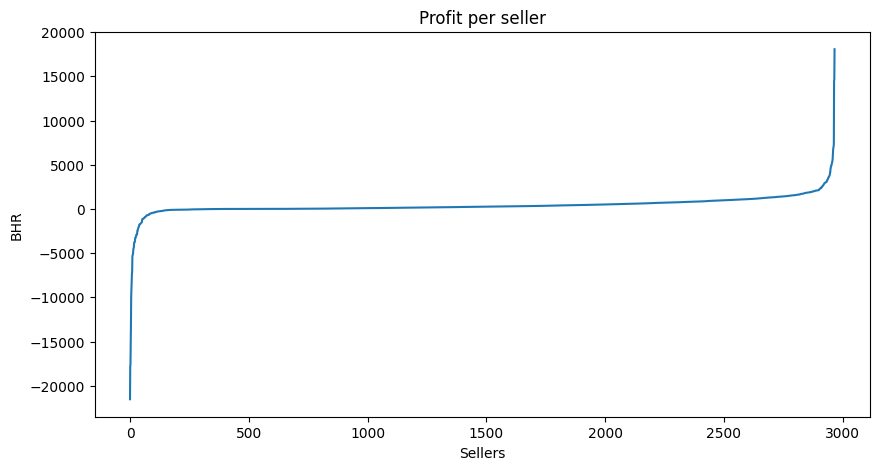

In [15]:
plt.figure(figsize=(10,5))
sorted_df.profits.plot()
plt.title('Profit per seller')
plt.xlabel('Sellers')
plt.ylabel('BHR');

Findings:
- Small amount of worst sellers contribute to large proportion of losses
- Small amount of best sellers contribute to large proportion of profits
- Most sellers do not contribute much to profit or losses

### Answering the problem statement

Analysis steps to address the problem statement:  

1. Create a function that will calculate the IT Costs.

2. Remove sellers one by one, starting from the one with the lowest profit.

3. For each seller removed, compute the financial impact on Olists profits.

4. Find an optimal number of sellers to remove that maximizes Olists profit.

#### Creating IT costs function

The IT costs function was given in section 1.2.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
- $\alpha = 3157.27$
- $\beta = 978.23$

In [16]:
def it_costs(n_sellers,n_products):
    return round(3157.27*(np.sqrt(n_sellers))+978.23*(np.sqrt(n_products)))


#### Removing the worst sellers one by one

In [17]:
# save results of the loop in these lists
net_profit = []
num_sellers = []
cumulative_it_costs = []
profits_sellers = []
# loop over range of sellers while removing one row each time
for i in range(len(sorted_df['profits'])):
    net_profit.append(sorted_df.iloc[i:]['profits'].sum() \
        - it_costs(sorted_df.iloc[i:]['profits'].count(), sorted_df.iloc[i:]['n_products'].sum()))
    num_sellers.append(sorted_df.iloc[i:]['profits'].count())
    cumulative_it_costs.append(it_costs(sorted_df.iloc[i:]['profits'].count(), sorted_df.iloc[i:]['n_products'].sum()))
    profits_sellers.append(sorted_df.iloc[i:]['profits'].sum())

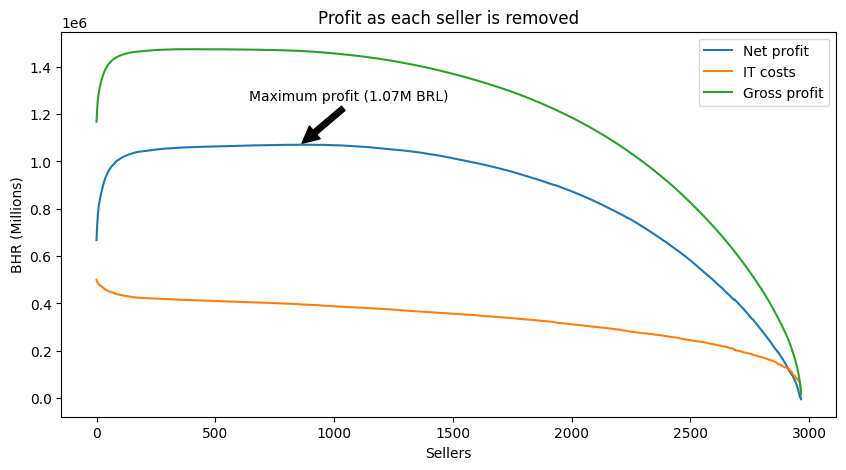

In [18]:
plt.figure(figsize=(10,5))
plt.plot(net_profit, label='Net profit')
plt.plot(cumulative_it_costs, label='IT costs')
plt.plot(profits_sellers, label='Gross profit')
plt.title('Profit as each seller is removed')
plt.xlabel('Sellers')
plt.ylabel('BHR (Millions)')
plt.annotate('Maximum profit (1.07M BRL)',
            xy=(855, 1068160), xycoords='data',
            xytext=(0.5, 0.85), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.legend();

In [26]:
sellers_to_remove = net_profit.index(np.max(net_profit))+1
max_profit = np.max(net_profit)
current_profit = sorted_df['profits'].sum()-it_costs(sorted_df['profits'].count(), sorted_df['n_products'].sum())
percentage_sellers_to_remove = round(sellers_to_remove/len(num_sellers)*100)
profit_saved = round(max_profit) - round(current_profit)
percentage_change = round((max_profit/current_profit)*100,1)
print(f'Sellers to remove: {sellers_to_remove}')
print(f'Percentage of sellers to remove: {percentage_sellers_to_remove}%') 
print(f'Profit that was achieved before removing worst sellers: {int(current_profit)} BRL')
print(f'Maximum profit that could have been achieved after removing worst sellers: {int(max_profit)} BRL')
print(f'Difference in profit margin: {profit_saved} BRL')
print(f'Percentage increase in profit that could have been achieved: {percentage_change}%')

Sellers to remove: 856
Percentage of sellers to remove: 29%
Profit that was achieved before removing worst sellers: 667609 BRL
Maximum profit that could have been achieved after removing worst sellers: 1070976 BRL
Difference in profit margin: 403367 BRL
Percentage increase in profit that could have been achieved: 160.4%


### Recommendation

- Based on the findings of our analysis, Olist could have cut costs and thus maximized profit, by removing the worst 856 sellers based on their review scores. This equates to 29% of the lowest rated sellers.
- According to our model this would have saved Olist 0.4M BRL over the analysis period.
- Profits would have been 1.07M BRL, a 160.4% change from the actual 0.67M profits.

Therefore, Olist should remove 29% of their worst reviewed sellers from their platform going forward, if they wish to operate efficiently and maximize profit.